In [1]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bokeh

# in your notebook cell
import sys

# path relative to your notebook
sys.path.insert(0, '../src')

# import as usual
import functions

# autoreload
%load_ext autoreload
%autoreload 2

#defining DataFrame
df = functions.read_file('../data/PIRUS_March2023/PIRUS_V4.xlsx')


import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
#from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
df.shape

(3203, 130)

## Cleaning Data

In [3]:
#Checking different columns against the different populations (violent/non-violent/military/non-military)

print("Non Violent Mil:\n", df[(df["Military"] == 1) & (df["Violent"] == 0)].groupby(["Trauma"]).size().sort_values(ascending=False))
print("\nViolent Mil:\n", df[(df["Military"] == 1) & (df["Violent"] == 1)].groupby(["Trauma"]).size().sort_values(ascending=False))
print("\nNon Violent Civ:\n", df[(df["Military"] == 0) & (df["Violent"] == 0)].groupby(["Trauma"]).size().sort_values(ascending=False))
print("\nViolent Civ:\n", df[(df["Military"] == 0) & (df["Violent"] == 1)].groupby(["Trauma"]).size().sort_values(ascending=False))

# print(df["Social_Stratum_Adulthood"].value_counts())

Non Violent Mil:
 Trauma
 0     70
-99    61
 1     17
 2     13
 3     10
dtype: int64

Violent Mil:
 Trauma
-99    111
 0      86
 1      57
 2      33
 3      12
dtype: int64

Non Violent Civ:
 Trauma
-99    375
 0     368
 1      46
 2      42
 3      13
dtype: int64

Violent Civ:
 Trauma
-99    564
 0     522
 2      75
 1      71
 3      22
dtype: int64


In [4]:
# df.head()

df["Time_US_Months"].dtype

dtype('int64')

In [5]:
saved_cols = ['Subject_ID', 'Year_Exposure',
       'Violent','Foreign_Fighter', 'Group_Membership', 'Actively_Recruited', 'Actively_Connect',
       'Role_Group', 'Clique',
       'Internet_Radicalization', 'Media_Radicalization', 'Social_Media',
       'Social_Media_Frequency', 'Radicalization_Islamist',
       'Radicalization_Far_Right', 'Radicalization_Far_Left',
       'Radicalization_Single_Issue', 'External_Rad', 'Rad_duration',
       'Radical_Beliefs', 'US_Govt_Leader', 'Foreign_Govt_Leader',
       'Event_Influence1', 'Radicalization_Place', 'Broad_Ethnicity',
       'Age', 'Marital_Status', 'Children', 'Gender',
       'Religious_Background', 'Convert',
       'Time_US_Months', 'Immigrant_Generation',
       'Education', 'Student', 'Employment_Status', 'Work_History',
       'Military', 'Foreign_Military',
       'Abuse_Child', 'Abuse_Adult', 'Abuse_type1',
       'Psychological', 'Alcohol_Drug', 'Radical_Friend',
       'Radical_Family', 'Radical_Signif_Other',
       'Previous_Criminal_Activity', 'Previous_Criminal_Activity_Type1',
       'Gang', 'Trauma', 'Other_Ideologies', 'Angry_US', 'Group_Grievance',
       ]

In [6]:
#Filter for columns I want
col_i_want = [
       'Violent','Group_Membership',
       'Internet_Radicalization',
       'Age', 'Marital_Status', 'Children', 'Gender',
       'Religious_Background',
       'Education',
       'Military',
       'Psychological', 'Alcohol_Drug',
       'Previous_Criminal_Activity',
       'Angry_US', 'Group_Grievance',
       ]

#Counting columns
print(len(col_i_want))

15


In [7]:
#Making a DF consisting of only columns I want
setup_df = df[col_i_want]

#Check for any null values
setup_df.isnull().sum()

#Check for any nan values
setup_df.isna().sum()


Violent                       0
Group_Membership              0
Internet_Radicalization       0
Age                           0
Marital_Status                0
Children                      0
Gender                        0
Religious_Background          0
Education                     0
Military                      0
Psychological                 0
Alcohol_Drug                  0
Previous_Criminal_Activity    0
Angry_US                      0
Group_Grievance               0
dtype: int64

In [8]:
#Checking the correlation between 
# sns.heatmap(setup_df.corr())

In [9]:
#Splitting DF into military and civillians
mil_only = setup_df[setup_df["Military"] == 1]

civ_only = setup_df[setup_df["Military"] == 0]

In [10]:
#checking why shape is different
print(mil_only["Military"].value_counts())
print(civ_only["Military"].value_counts())
print(df["Military"].value_counts())

# Different because I will not include those with UNK military status


1    470
Name: Military, dtype: int64
0    2098
Name: Military, dtype: int64
 0     2098
-99     635
 1      470
Name: Military, dtype: int64


## Hypothesis Tests

In [11]:
mil_only.head(8)

,Violent,Group_Membership,Internet_Radicalization,Age,Marital_Status,Children,Gender,Religious_Background,Education,Military,Psychological,Alcohol_Drug,Previous_Criminal_Activity,Angry_US,Group_Grievance
6,0,3,1,32,1,0,2,15,6,1,2,1,0,1,0
20,0,3,1,52,3,2,2,-99,3,1,2,1,1,1,0
22,1,3,1,39,2,4,2,-99,-99,1,2,0,1,1,0
23,1,3,1,41,1,-99,2,-99,-99,1,0,0,0,0,0
34,0,3,1,35,2,0,1,-99,3,1,0,0,1,1,0
52,1,3,1,40,2,2,2,-99,-99,1,1,0,0,1,0
54,0,3,1,44,2,3,2,-99,4,1,0,0,0,1,0
60,1,3,1,33,1,1,2,7,3,1,0,0,0,1,0


In [12]:
import scipy.stats as stats
from scipy.stats import pearsonr, ttest_ind, ttest_1samp
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler

# sub_sahara_education_data = final_data[final_data['region_txt'] == 'Sub-Saharan Africa']['education_level']

In [22]:
mil_only.shape

(470, 15)

In [14]:

violent_mil = mil_only[['Violent']]

violent_civ = civ_only[['Violent']]

violent_civ_mean = np.mean(violent_civ)
violent_mil_mean = np.mean(violent_mil)

t_statistic, p_value = stats.ttest_ind(violent_mil, violent_civ, equal_var=False)
print(t_statistic, p_value)

# print(violent_mil_mean)
# print(violent_civ_mean)

#possibly due to the diffence in sample sizes, the p value fell about 5% 
#Therefore I cannot reject the null hypothesis


[1.55945378] [0.11933857]


In [94]:
#Normalizing distributions between Mil and Civ
#Boostrapping

# print("Outside function:", len(bootstrap(violent_mil, num_bootstrap_samples=len(violent_mil))))
practice_mil = functions.bootstrap(violent_mil)
practice_civ = functions.bootstrap(violent_civ)

In [95]:

print("mil:", np.mean(practice_mil), np.std(practice_mil))
print("civ:", np.mean(practice_civ), np.std(practice_civ))

mil: 0.6363795744680851 0.021744942897201067
civ: 0.5975299809342232 0.010860459019258237


In [61]:
t_statistic, p_value = stats.ttest_ind(practice_mil, practice_civ, equal_var=False)
print(t_statistic, p_value)

155.0744650702409 0.0


In [64]:
np.mean(practice_mil)

0.6359340425531915

In [66]:
from scipy.stats import norm

In [75]:
np.std(practice_mil)/(len(practice_mil))

2.2355686682045873e-06

In [76]:
norm_mil = norm.fit(practice_mil)


In [79]:
norm_mil

(0.6359340425531915, 0.022355686682045874)

In [87]:

# mil_distribution = norm(loc=np.mean(practice_mil), scale=np.std(practice_mil)/(len(practice_mil)))
mil_distribution = norm(loc=np.mean(practice_mil), scale=np.std(practice_mil, ddof=1))
# civ_distribution = norm(loc=np.mean(practice_civ), scale=np.std(practice_civ)/(len(practice_civ)))
civ_distribution = norm(loc=np.mean(practice_civ), scale=np.std(practice_civ, ddof=1))
critical_value = civ_distribution.ppf(0.025)
critical_value2 = civ_distribution.ppf(0.975)
# critical_value = null_distribution.ppf(0.95)

print(critical_value, critical_value2)

0.5768005048195154 0.6183349575255751


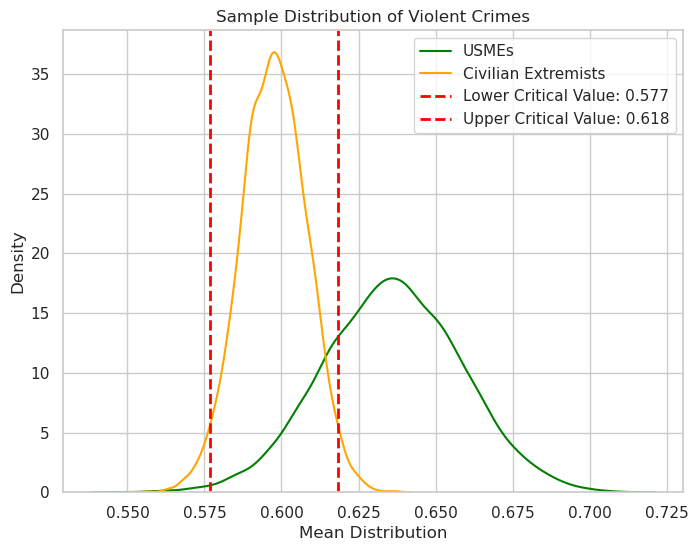

In [93]:
# plt.hist(practice, color="blue")

plt.figure(figsize=(8,6))
sns.set(style='whitegrid')

#Plot the KDE plots

# sns.kdeplot(violent_mil.squeeze(), color="red", palette="viridis")
sns.kdeplot(practice_mil, color="green", label="USMEs")
# sns.kdeplot(violent_civ, color="green", palette="viridis")
sns.kdeplot(practice_civ, color="orange", label="Civilian Extremists")
plt.axvline(critical_value, color='red', linestyle='dashed',
 linewidth=2, label=f'Lower Critical Value: {critical_value:.3f}')
plt.axvline(critical_value2, color='red', linestyle='dashed',
 linewidth=2, label=f'Upper Critical Value: {critical_value2:.3f}')
plt.title("Sample Distribution of Violent Crimes")
plt.xlabel("Mean Distribution")
plt.legend()


In [47]:
violent_mil.sample(10, replace=True).mean().iloc[0]

0.8

(array([  19.,  104.,  590., 1666., 2809., 2744., 1504.,  465.,   84.,
          15.]),
 array([0.55319149, 0.57      , 0.58680851, 0.60361702, 0.62042553,
        0.63723404, 0.65404255, 0.67085106, 0.68765957, 0.70446809,
        0.7212766 ]),
 <BarContainer object of 10 artists>)

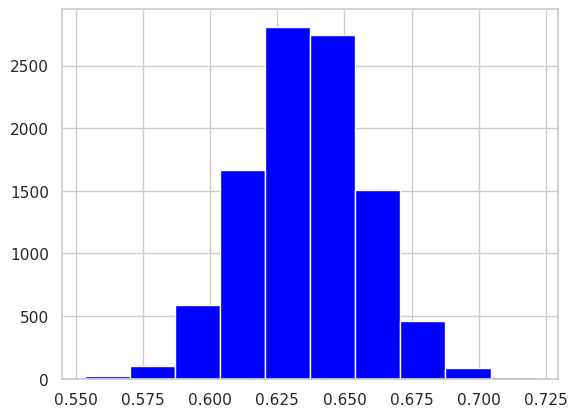

In [52]:
sample_means = []
for i in range(10000):
  sample_means.append(np.mean(np.random.choice(violent_mil.squeeze(), size=470, replace=True)))
# print(sample_means)

plt.hist(sample_means, color="blue")


## Convert Values

In [96]:
#mil_only
#civ_only
mil_only.columns.values

array(['Violent', 'Group_Membership', 'Internet_Radicalization', 'Age',
       'Marital_Status', 'Children', 'Gender', 'Religious_Background',
       'Education', 'Military', 'Psychological', 'Alcohol_Drug',
       'Previous_Criminal_Activity', 'Angry_US', 'Group_Grievance'],
      dtype=object)

In [ ]:
# Converting values to make proper logistic regression

violent = {
  
}
sub_groups = {
1 : "Militia/gun rights",
2 : "Neo-Nazi",
3 : "Xenophobic",
4 : "Anti-government",
5 : "Christian Identity",
6 : "Environmentalist",
7 : "New Left",
8 : "Black Nationalist",
9 : "Communist",
10 : "Anarchist",
11 : "Islamist",
12 : "Puerto Rican Nationalist",
13 : "Irish Republican Army",
14 : "Cult",
15 : "Anti-abortion",
16 : "Jewish Defense League",
17 : "Anti-LGBTQ",
18 : "Other",
19 : "Male supremacist",
20 : "Moorish sovereign",
21 : "Pro-Trump extremist",
22 : "Anti-Trump extremist",
23 : "Anti-Law Enforcement"
}


## Make Dummies

In [ ]:
# Make Dummies

## Make the Logistic Regression 

In [ ]:
# Make Logistic Regression